# A Hybrid Probabilistic Multiobjective Evolutionary Algorithm for Commercial Recommendation Systems

Este archivo contiene una implementación del algoritmo HP-MOEA (Hybrid Probabilistic Multiobjective Evolutionary Algorithm), el cual integra técnicas de sistemas de recomendación con algoritmos evolutivos de optimización multiobjetivo. La descripción detallada del enfoque original se encuentra en este [paper](https://ieeexplore.ieee.org/abstract/document/9363322).


## Requerimientos

Para este proyecto se utilizan las siguientes bibliotecas: NumPy, Pandas, Scikit-learn, Pymoo y Sortedcontainers.

Asegúrese de instalar las dependencias ejecutando el siguiente comando:

In [1]:
%pip install numpy pandas scikit-learn pymoo sortedcontainers

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Preprocesamiento de datos

Iniciaremos con el preprocesamiento de los datos utilizando el dataset MovieLens, desarrollado por la Universidad de Minnesota, el cual está disponible para uso libre con fines de investigación. Este dataset contiene calificaciones asignadas por usuarios a diversas películas. En esta implementación se utilizará la versión de 100,000 calificaciones, que abarca el período comprendido entre 1996 y 2018.

Para más información sobre el dataset, puede consultarse el siguiente [enlace oficial](https://grouplens.org/datasets/movielens/).

Para ver detalles de la implemetación del preprocesamiento, vea el archivo `preprocess.py`.

In [2]:
dataset_latest_small_path = '../../datasets/ml-latest-small/ratings.csv'
dataset_100k_path = '../../datasets/ml-100k/ratings.csv'
dataset_20m_path = '../../datasets/movielens-20m-dataset/rating.csv'
data_path = './data'
top_usuarios = 10000
newcomer_filter = 5

In [3]:
import preprocess

preprocess.main(dataset_100k_path, data_path, top_usuarios, newcomer_filter)


Leyendo el dataset desde: ../../datasets/ml-100k/ratings.csv

Tamaño del dataframe original: 100000
Eliminando la columna 'timestamp'
Ordenando el dataset por la primera columna...
Seleccionando los 10000 usuarios películas más comunes...
Filtrando el dataframe para que solo contenga los usuarios seleccionados...
Películas que aparecen más de 5 veces: 1298
Películas que aparecen menos o igual a 5 veces (Newcomers): 384

Cantidad total de usuarios: 943
Cantidad total de peliculas: 1682
Tamaño del dataframe actual: 100000

Generando users2movie_ratings...
[2025-05-05 18:29:12] [INFO] [update_users2movie_ratings] [0.07 segundos] 5.0%
[2025-05-05 18:29:12] [INFO] [update_users2movie_ratings] [0.24 segundos] 15.0%
[2025-05-05 18:29:12] [INFO] [update_users2movie_ratings] [0.43 segundos] 25.0%
[2025-05-05 18:29:12] [INFO] [update_users2movie_ratings] [0.64 segundos] 35.0%
[2025-05-05 18:29:12] [INFO] [update_users2movie_ratings] [0.86 segundos] 45.0%
[2025-05-05 18:29:13] [INFO] [update_use

## Filtrado colaborativo basado en usuarios

El siguente paso luego del preprocesamiento de los datos para HP-MOEA, es calcular la puntuación esperada de los ítems que los usuarios aun no han calificado, para ello se emplea el filtrado colaborativo basado en usuarios, la cual es la tecnica mas sencilla de los S.R.

Para ver mas detalles de como se implemento el filtrado colaborativo basado en usuarios, ver el archivo `User_based_CF.py`.


In [4]:
import User_based_CF

K = 20
limit = 5
eliminar_newcomers = True
calcular_pesos = False # Debe estar True la primera vez que se ejecuta
hacer_test = False

usermovie2predict_rating = User_based_CF.main(data_path, K, limit, eliminar_newcomers, calcular_pesos, hacer_test)

Cargamos los datos preprocesados...

Longitud de los datos preprocesados:
users2movie_ratings:  1045569
movies_info:  159541
Eliminando newcomers...
[2025-05-05 18:29:15] [INFO] [DELETING_NEWCOMERS] [0.00 segundos] 0.0%
[2025-05-05 18:29:15] [INFO] [DELETING_NEWCOMERS] [0.02 segundos] 4.95%
[2025-05-05 18:29:15] [INFO] [DELETING_NEWCOMERS] [0.03 segundos] 9.9%
[2025-05-05 18:29:15] [INFO] [DELETING_NEWCOMERS] [0.05 segundos] 14.84%
[2025-05-05 18:29:15] [INFO] [DELETING_NEWCOMERS] [0.07 segundos] 19.79%
[2025-05-05 18:29:15] [INFO] [DELETING_NEWCOMERS] [0.08 segundos] 24.74%
[2025-05-05 18:29:15] [INFO] [DELETING_NEWCOMERS] [0.10 segundos] 29.69%
[2025-05-05 18:29:15] [INFO] [DELETING_NEWCOMERS] [0.12 segundos] 34.64%
[2025-05-05 18:29:15] [INFO] [DELETING_NEWCOMERS] [0.13 segundos] 39.58%
[2025-05-05 18:29:15] [INFO] [DELETING_NEWCOMERS] [0.15 segundos] 44.53%
[2025-05-05 18:29:15] [INFO] [DELETING_NEWCOMERS] [0.17 segundos] 49.48%
[2025-05-05 18:29:15] [INFO] [DELETING_NEWCOMERS] [0.

## Carga de datos preprocesados y definición de parámetros del algoritmo

Se cargan los datos limpios y se definen como constantes globales los parámetros clave del algoritmo.

In [5]:
import numpy as np

#np.set_printoptions(threshold=np.inf)

data_path = './data'

#Configuración del paper
u_turning_point = 500
L_tamano_lista = 10
N_tamano_poblacion = 100
T_iteraciones = 3000
Pm_probabilidad_mutacion = 1/L_tamano_lista
r_max_calificacion_maxima = 5
max_profit = 1
max_novelty = 1
max_popularity = 1
n_obj = 3

nice_seed = 69

poblacion_global = []

historial_fitness = []

use_precalculated_CF = True
CF_config = {
    "K": 25,
    "limit": 5,
    "calcular_pesos": False,
    "hacer_test": False,
}

test_mode = True
if test_mode:
    u_turning_point = 5 #5
    T_iteraciones = 150 #150
    L_tamano_lista = 10 #10
    N_tamano_poblacion = 100 #100
    Pm_probabilidad_mutacion = 1/10

In [6]:
import os
import logger

from classes.Movies_info import Movies_info
from classes.Users import Users

log = logger.logger_class('LOAD_DATASET')

log.info('Cargamos los datos preprocesados')

if  os.path.exists(f'{data_path}/users2movie_ratings.json') and \
    os.path.exists(f'{data_path}/movies_info.json') and \
    os.path.exists(f'{data_path}/users2predict_movie_ratings.json')   :

    with open(f'{data_path}/users2movie_ratings.json', 'r') as f:
        users2movie_ratings_json = f.read()

    with open(f'{data_path}/movies_info.json', 'r') as f:
        movies_info_json = f.read()

    with open(f'{data_path}/users2predict_movie_ratings.json', 'r') as f:
        users2predict_movie_ratings_json = f.read()

    print('\nLongitud de los datos preprocesados:')
    print("users2movie_ratings: ", len(users2movie_ratings_json))
    print("users2predict_movie_ratings: ", len(users2predict_movie_ratings_json))
    print("movies_info: ", len(movies_info_json))

    users2movie_ratings = Users(fromJson=users2movie_ratings_json)
    users = users2movie_ratings.get_all_users()
    U_cant_usuarios = users2movie_ratings.get_len_users()
    users_ratings_data = {user.get_id(): user for user in users2movie_ratings.get_all_users()}

    users2predict_movie_ratings = Users(fromJson=users2predict_movie_ratings_json)
    users_predicted_ratings = users2predict_movie_ratings.get_all_users()
    user_movie_predict_ratings = users2predict_movie_ratings.get_user_movie_ratings()

    movies_info = Movies_info(fromJson=movies_info_json)
    movies_ids = movies_info.get_all_movie_ids()
    movies_ids_set = set(movies_ids)
    new_comers_ids = movies_info.get_all_newcomers_ids()
    newcomers_id_set = set(new_comers_ids)
    movies2profit = movies_info.get_movies_with_profits()
    movies2popularity = movies_info.get_movies_popularity()
    top_movies = set(movies_info.get_movies_id_sort_by_popularity())

    ID_MIN = min(movies_ids)
    ID_MAX = max(movies_ids)

    print("\nU_cant_usuarios:", U_cant_usuarios)
    print("Cantidad de peliculas:", len(movies_ids_set))
    print("ID_MIN (movies):", ID_MIN)
    print("ID_MAX (movies):", ID_MAX)
    print("Cantidad de newcomers:", len(new_comers_ids))
    log.success('Datos preprocesados cargados correctamente')


[2025-05-05 18:29:26] [INFO] [LOAD_DATASET] [0.00 segundos] Cargamos los datos preprocesados

Longitud de los datos preprocesados:
users2movie_ratings:  1045569
users2predict_movie_ratings:  34565337
movies_info:  159541

U_cant_usuarios: 943
Cantidad de peliculas: 1682
ID_MIN (movies): 1
ID_MAX (movies): 1682
Cantidad de newcomers: 384
[2025-05-05 18:29:27] [SUCCESS] [LOAD_DATASET] [0.88 segundos] Datos preprocesados cargados correctamente


## Definición de clases y funciones auxiliares
Esta sección contiene clases y funciones auxiliares utilizadas para la ejecución de la clase principal y el ciclo de procesamiento.

In [7]:
import hashlib

def hash_matrix_func(matrix):
    matrix_str = ''.join(map(str, matrix.flatten()))
    return hashlib.sha256(matrix_str.encode()).hexdigest()

In [8]:
np.random.seed(nice_seed)

class Individuo():
    def __init__(self, new_matrix=None):
        global max_profit, max_novelty, max_popularity
        if isinstance(new_matrix, (np.ndarray, list)):
            self.matrix = np.array(new_matrix)
        else:
            matrix_aux = []
            for user in users:
                movies_ids_user_rated = set(user.get_movie_ids())
                posibles_ids = list(movies_ids_set - movies_ids_user_rated)
                matrix_aux.append(np.random.choice(posibles_ids, L_tamano_lista, replace=False))
            self.matrix = np.array(matrix_aux)

        self.profit = None
        self.novelty = None
        self.popularity = None

        self.rank = None
        self.crowding_distance = None
        self.hv_contribution = None

        self.hash = hash_matrix_func(self.matrix)

    def get_profit(self):
        if self.profit == None:
            self.profit = self._calculate_profit()
        return self.profit

    def get_novelty(self):
        if self.novelty == None:
            self.novelty = self._calculate_novelty()
        return self.novelty

    def get_popularity(self):
        if self.popularity == None:
            self.popularity = self._calculate_popularity()
        return self.popularity

    def get_fitness(self):
        self.fitness = [-self.get_profit() / max_profit, -self.get_novelty() / max_novelty, -self.get_popularity() / max_popularity]
        return self.fitness

    def _calculate_profit(self):
        profit_total = 0

        for user_id, lista_recomendacion in enumerate(self.matrix, start=1):
            for movie_id in lista_recomendacion:
                if movie_id in newcomers_id_set:
                    profit = 1
                else:
                    r_calificacion = user_movie_predict_ratings[(user_id, movie_id)]
                    profit_i = movies_info.get_profit_by_movie_id(movie_id)
                    profit = (r_calificacion / r_max_calificacion_maxima) * profit_i
                profit_total += profit

        return profit_total

    def _calculate_novelty(self):
        novelty = 0
        for _, lista_recomendacion in enumerate(self.matrix, start=1):
            for movie_id in lista_recomendacion:
                if movie_id in newcomers_id_set:
                    novelty += 1
        return novelty

    def _calculate_popularity(self):
        popularity = 0
        for _, lista_recomendacion in enumerate(self.matrix, start=1):
            for movie_id in lista_recomendacion:
                popularity = popularity + movies2popularity[movie_id]
        return popularity

    def get_matrix(self):
        return self.matrix

    def get_hash(self):
        return self.hash

    def get_matrix_flatten(self):
        return self.matrix.flatten()

    def get_rank(self):
        return self.rank

    def set_rank(self, new_rank):
        self.rank = new_rank

    def get_crowding_distance(self):
        return self.crowding_distance

    def set_crowding_distance(self, new_crowding_distance):
        self.crowding_distance = new_crowding_distance

    def get_hv_contribution(self):
        return self.hv_contribution

    def set_hv_contribution(self, new_hv_contribution):
        self.hv_contribution = new_hv_contribution

    def get_row(self, index):
        return self.matrix[index]

    def recalcular(self):
        self.profit = self._calculate_profit()
        self.novelty = self._calculate_novelty()
        self.popularity = self._calculate_popularity()
        self.fitness = [-self.profit / max_profit, -self.novelty / max_novelty, -self.popularity / max_popularity]
        self.hash = hash_matrix_func(self.matrix)

        self.rank = None
        self.crowding_distance = None
        self.hv_contribution = None

    def replace_element_in_matrix(self, user, position, new_value):
        self.matrix[user, position] = new_value
        self.recalcular()

In [9]:

class Poblacion():

    def __init__(self, individuos, initial_population = False):
        if initial_population:
            self.poblacion = {individuo.get_hash(): individuo for individuo in individuos}
            self.fitnessF = None
        elif individuos != []:
            self.poblacion = {}
            for individuo_matrix in individuos.X:
                individuo_obj = poblacion_global.get_by_matrix_flatted(individuo_matrix)
                self.poblacion[individuo_obj.get_hash()] = individuo_obj
            self.poblacionX = individuos.X
            self.fitnessF = individuos.F

    def get_by_matrix_flatted(self, matrix_flatted):
        matrix = self.reshape_matrix(matrix_flatted)
        hash_matrix = hash_matrix_func(matrix)
        return self.poblacion[hash_matrix]

    def get_all_matrix(self):
        return [individuo.get_matrix() for individuo in self.poblacion.values()]

    def get_all_matrix_flatten(self):
        return [individuo.get_matrix_flatten() for individuo in self.poblacion.values()]

    def reshape_matrix(self, matrix):
        return matrix.reshape(U_cant_usuarios, L_tamano_lista)

    def add_individual(self, individual):
        if individual.get_hash() not in self.poblacion:
            self.poblacion[individual.get_hash()] = individual

    def replace_individual(self, old_individual, new_individual):
        old_hash = old_individual.get_hash()
        new_hash = new_individual.get_hash()
        if old_hash in self.poblacion:
            del self.poblacion[old_hash]
        self.poblacion[new_hash] = new_individual

    def get_total_fitness(self):
        total_fitness = []
        for individuo in self.poblacion.values():
            total_fitness.append(individuo.get_fitness())
        return total_fitness

    def get_all_individual_as_array(self):
        return list(self.poblacion.values())

    def get_fitness_F(self):
        return self.fitnessF

    def get_poblacion_X(self):
        return self.poblacionX

    def get_history(self):
        return self.history

    def get_all_individuals(self):
        return list(self.poblacion.values())

### Obtener los individuos maximos

In [10]:

np.random.seed(nice_seed)

def get_individual_max_profit():
    global max_profit
    matrix_max_profit = []

    for user in users:
        user_id = user.get_id()
        movies_predict = users2predict_movie_ratings.get_movies_and_ratings_by_user_id(user_id)

        movies_predict = [(movie_id, rating) for movie_id, rating in movies_predict if movie_id not in newcomers_id_set]
        sorted_movies = sorted(movies_predict, key=lambda x: (movies2profit.get(x[0]), x[1]), reverse=True)

        matrix_max_profit.append([movie for movie, _ in sorted_movies[:L_tamano_lista]])

    individual_max_profit = Individuo(matrix_max_profit)
    max_profit = individual_max_profit.get_profit()

    return individual_max_profit


def get_individual_max_novelty():
    global max_novelty
    matrix_max_novelty = []

    for user in users:
        movies_ids_user_rated = set(user.get_movie_ids())
        posibles_ids = list(newcomers_id_set - movies_ids_user_rated)
        matrix_max_novelty.append(np.random.choice(posibles_ids, L_tamano_lista, replace=False))

    individual_max_novelty = Individuo(matrix_max_novelty)
    max_novelty = individual_max_novelty.get_novelty()

    return individual_max_novelty

def get_individual_max_popularity():
    global max_popularity
    matrix_max_popularity = []

    for user in users:
        movies_ids_user_rated = set(user.get_movie_ids())
        posibles_ids = list(top_movies - movies_ids_user_rated)
        matrix_max_popularity.append(posibles_ids[:L_tamano_lista])

    individual_max_popularity = Individuo(matrix_max_popularity)
    max_popularity = individual_max_popularity.get_popularity()

    return individual_max_popularity


## Problema multiobjetivo y operadores geneticos

### Definición del problema

In [11]:
from pymoo.core.problem import Problem

class HP_MOEA_Problem(Problem):

    def __init__(self, log, *args, **kwargs):
        n_var = U_cant_usuarios * L_tamano_lista
        xl = [ID_MIN for _ in range(n_var)]
        xu = [ID_MAX for _ in range(n_var)]
        self.log = log

        super().__init__(n_var = n_var, n_obj = n_obj, xl = xl, xu = xu, *args, **kwargs)

    def _evaluate(self, x, out, *args, **kwargs):
        self.log.info('Iniciando evaluación con los valores del fitness...')
        res = []
        lenX = len(x)
        for i, matrix in enumerate(x):
            individuo = poblacion_global.get_by_matrix_flatted(matrix)
            res.append(individuo.get_fitness())
            self.log.percentage(i, lenX, mensaje='Evaluación: ')

        out["F"] = np.array(res)
        self.log.success('Termino la evaluación')
        super()._evaluate(x, out, *args, **kwargs)

In [12]:
from pymoo.core.sampling import Sampling

class HP_MOEA_Sampling(Sampling):

    def __init__(self, initial_population):
        self.initial_population = initial_population
        super().__init__()

    def _do(self, problem, n_samples, **kwargs):
        return self.initial_population

### Definición del operador genetico de mutación

In [13]:
from pymoo.core.mutation import Mutation
from pymoo.core.population import Population

np.random.seed(nice_seed)

def get_random_id_not_in(ban_list):
    posibles_ids = [movie_id for movie_id in movies_ids_set if movie_id not in ban_list]
    return np.random.choice(posibles_ids)

class HP_MOEA_SP_Mutation(Mutation):

    def __init__(self, Pm_probabilidad_mutacion, log):
        super().__init__()
        self.Pm_probabilidad_mutacion = Pm_probabilidad_mutacion
        self.log = log

    def _do(self, problem, X, **kwargs):
        global poblacion_global
        self.log.info("Iniciando operador de mutación...")

        X_mut = X.copy()

        for matrix_i, matrix in enumerate(X):
            if np.random.random() < self.Pm_probabilidad_mutacion:
                individuo = poblacion_global.get_by_matrix_flatted(matrix)

                user_i = np.random.randint(U_cant_usuarios)
                position = np.random.randint(L_tamano_lista)

                lista_recomendacion = individuo.get_row(user_i)
                user = users2movie_ratings.get_user_by_id(user_i + 1)
                movies_ids_user_rated = user.get_movie_ids()
                ban_list = set(movies_ids_user_rated + list(lista_recomendacion))
                nueva_pelicula = get_random_id_not_in(ban_list)

                #self.log.info(f"Individuo {matrix_i}, mutando en posición ({user_i}, {position}) reemplazando película {lista_recomendacion[position]} con {nueva_pelicula}")
                individuo.replace_element_in_matrix(user_i, position, nueva_pelicula)
                X_mut[matrix_i] = individuo.get_matrix_flatten()
                poblacion_global.add_individual(individuo)
            #self.log.percentage(matrix_i, len(X), mensaje='Operador de mutación: ')

        self.log.success('Operador de mutación finalizado correctamente')
        return X_mut


def test_HP_MOEA_SP_Mutation():
    poblacion_array = []
    for user in users_predicted_ratings[:5]:
        movies_ids_user_rated = user.get_movie_ids()
        posibles_ids = list(movies_ids_set - set(movies_ids_user_rated))
        lista_recomendacion = np.random.choice(posibles_ids, L_tamano_lista, replace=False)
        poblacion_array.append(lista_recomendacion)

    poblacion_array = np.array(poblacion_array)

    print("Población original:")
    print(poblacion_array)

    log = logger.logger_class('MUTACION_TEST')

    mutation = HP_MOEA_SP_Mutation(Pm_probabilidad_mutacion, log)

    # Create a Population object with the original population array
    pop = Population.new("X", poblacion_array.copy())

    # Apply the mutation operator
    mutated_pop = mutation._do(None, pop.get("X"))

    print("\nPoblación mutada:")
    print(mutated_pop)

    print("\nCambios detectados:")
    for i in range(len(poblacion_array)):
        original = poblacion_array[i]
        mutado = mutated_pop[i].reshape(L_tamano_lista)
        cambios = [(o, m) for o, m in zip(original, mutado) if o != m]
        if cambios:
            print(f"Usuario {i + 1}: {cambios}")

#test_HP_MOEA_SP_Mutation()

### Definición del operador genetico de cruce

Probabilidad genetica para NSGA-II

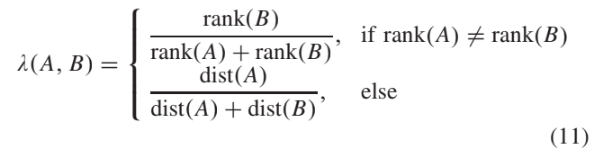

In [14]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

def lambda_NSGA2(A, B):
    rank_A = A.get_rank()
    rank_B = B.get_rank()

    if rank_A != rank_B and (rank_A + rank_B) != 0:
        return rank_B / (rank_A + rank_B)

    dist_A = A.get_crowding_distance()
    dist_B = B.get_crowding_distance()
    if (dist_A + dist_B) != 0:
        return dist_A / (dist_A + dist_B)

    return float('inf')

Probabilidad genetica para SMS-EMOA

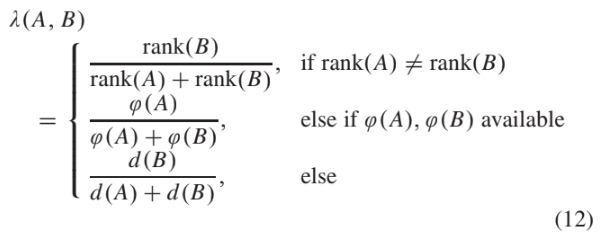

In [15]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

def lambda_SMS_EMOA(A, B):
    rank_A = A.get_rank()
    rank_B = B.get_rank()

    if rank_A != rank_B and (rank_A + rank_B) != 0:
        return rank_B / (rank_A + rank_B)

    contrib_A = A.get_hv_contribution()
    contrib_B = B.get_hv_contribution()

    if contrib_A is not None and contrib_B is not None and (contrib_A + contrib_B) != 0:
        return contrib_A / (contrib_A + contrib_B)

    dist_A = A.get_crowding_distance()
    dist_B = B.get_crowding_distance()
    if (dist_A + dist_B) != 0:
        return dist_A / (dist_A + dist_B)

    return float('inf')

Calculo de metricas de la población para el cruce

In [16]:
from pymoo.indicators.hv import Hypervolume
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.operators.survival.rank_and_crowding.metrics import get_crowding_function

def calculate_population_metrics(population, log):

    log.info('Calculando metricas de la población...')
    fitness_of_population = np.array([individuo.get_fitness() for individuo in population])
    reference_point = np.max(fitness_of_population, axis=0) + 1
    hv = Hypervolume(ref_point=reference_point)
    total_hv = hv.do(fitness_of_population)
    nds = NonDominatedSorting()
    fronts = nds.do(fitness_of_population, only_non_dominated_front=False)
    crowding_function = get_crowding_function("cd")

    for rank, front in enumerate(fronts):
        if len(front) == 0:
            continue

        front_fitness = fitness_of_population[front]
        crowding = crowding_function.do(front_fitness)

        for idx_in_front, idx_population in enumerate(front):
            individuo = population[idx_population]

            individuo.set_rank(rank)

            individuo.set_crowding_distance(crowding[idx_in_front])

            reduced_fitness = np.delete(fitness_of_population, idx_population, axis=0)
            reduced_hv = Hypervolume(ref_point=reference_point).do(reduced_fitness)
            hv_contrib = total_hv - reduced_hv

            individuo.set_hv_contribution(hv_contrib)
        #log.percentage(rank, len(fronts), mensaje='Metricas de la población: ')
    log.success('El calculo de metricas de población ha finalizado correctamente')

Funcion del operador genetico de cruce entre individuos.

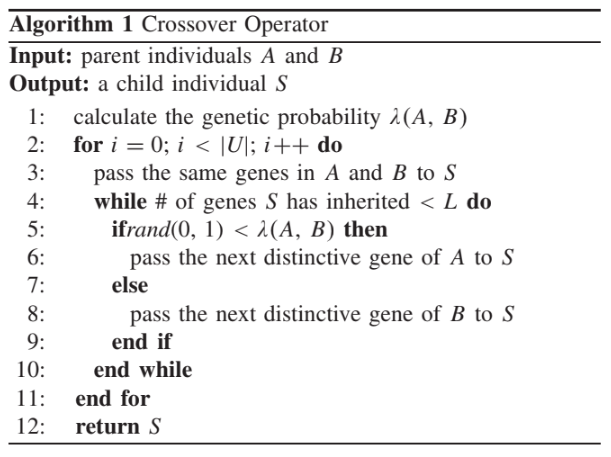

In [17]:

from pymoo.core.crossover import Crossover
from pymoo.indicators.hv import Hypervolume
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

np.random.seed(nice_seed)

class HP_MOEA_Crossover(Crossover):

    def __init__(self, log):
        # número de padres y número de hijos
        self.parents = 2
        self.offsprings = 1
        self.log = log
        super().__init__(n_parents=self.parents, n_offsprings=self.offsprings)

    def pass_same_genes(self, S_child, A_parent, B_parent):
        A_distinctive_genes = []
        B_distinctive_genes = []
        S_genes_size = 0

        for gene in A_parent:
            if gene in B_parent:
                S_child[S_genes_size] = gene
                S_genes_size += 1
            else:
                A_distinctive_genes.append(gene)

        for gene in B_parent:
            if gene not in A_parent:
                B_distinctive_genes.append(gene)

        return A_distinctive_genes, B_distinctive_genes, S_genes_size

    def crossover(self, A_parent, B_parent, algorithm_name):
        global poblacion_global
        S_child = np.zeros((U_cant_usuarios, L_tamano_lista), dtype=int)
        lambda_genetic_probability = lambda_NSGA2(A_parent, B_parent) if algorithm_name == 'NSGA2' else lambda_SMS_EMOA(A_parent, B_parent)
        for i in range(U_cant_usuarios):
            A_distinctive_genes, B_distinctive_genes, S_genes_size = self.pass_same_genes(S_child[i], A_parent.get_row(i), B_parent.get_row(i))
            A_index = 0
            B_index = 0

            for j in range(S_genes_size, L_tamano_lista):
                if np.random.random() < lambda_genetic_probability:
                    S_child[i][j] = A_distinctive_genes[A_index]
                    A_index+=1
                else:
                    S_child[i][j] = B_distinctive_genes[B_index]
                    B_index+=1

        new_child = Individuo(S_child)
        poblacion_global.add_individual(new_child)
        return new_child

    def _do(self, problem, X, **kwargs):
        global poblacion_global
        self.log.info("Iniciando operador de cruce...")

        n_parents, n_matings, n_var = X.shape

        algorithm = kwargs.get('algorithm')
        algorithm_name = algorithm.__class__.__name__

        Y_children = np.full((self.n_offsprings, n_matings, problem.n_var), None, dtype=object)

        for i in range(n_matings):
            A_parent = poblacion_global.get_by_matrix_flatted(X[0, i])
            B_parent = poblacion_global.get_by_matrix_flatted(X[1, i])
            S_child = self.crossover(A_parent, B_parent, algorithm_name)

            Y_children[0, i, :] = S_child.get_matrix_flatten()
            self.log.percentage(i, n_matings, mensaje='Operador de cruce: ')

        self.log.success("Operador de cruce finalizado correctamente")
        return Y_children


## Definición de la clase HP_MOEA_Class
Esta sección define la clase principal HP_MOEA_Class, encargada de gestionar la lógica central del algoritmo.

In [18]:

import copy
import logger
import User_based_CF as UBCF

from pymoo.optimize import minimize
from pymoo.indicators.hv import Hypervolume
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.sms import SMSEMOA


class HP_MOEA_Class():

    def __init__(self):
        self.log = logger.logger_class('HP_MOEA_CLASS')
        self.iteracion_actual = 0
        self.population = []
        self.log.info('Se inicializo una instancia de la clase HP_MOEA_CLASS, la configuración es:')
        self.log.info(f'test_mode = {test_mode}')
        self.log.info(f'u_turning_point = {u_turning_point}')
        self.log.info(f'L_tamano_lista = {L_tamano_lista}')
        self.log.info(f'N_tamano_poblacion = {N_tamano_poblacion}')
        self.log.info(f'T_iteraciones = {T_iteraciones}')
        self.log.info(f'Pm_probabilidad_mutacion = {Pm_probabilidad_mutacion}')
        self.log.info(f'r_max_calificacion_maxima = {r_max_calificacion_maxima}')


    def generate_initial_population(self):
        self.log.info('Inicializando población...')
        initial_population = []

        self.log.percentage(0, N_tamano_poblacion, mensaje='Población inicial: ')
        individual_max_profit = get_individual_max_profit()
        self.log.percentage(1, N_tamano_poblacion, mensaje='Población inicial: ')
        individual_max_novelty = get_individual_max_novelty()
        self.log.percentage(2, N_tamano_poblacion, mensaje='Población inicial: ')
        individual_max_popularity = get_individual_max_popularity()
        self.log.percentage(3, N_tamano_poblacion, mensaje='Población inicial: ')

        initial_population.append(individual_max_profit)
        initial_population.append(individual_max_novelty)
        initial_population.append(individual_max_popularity)

        for i in range(n_obj, N_tamano_poblacion):
            initial_population.append(Individuo())
            self.log.percentage(i, N_tamano_poblacion, mensaje='Población inicial: ')

        self.set_population(initial_population, initial_population = True)

        self.log.success('Población inicializada correctamente')
        return self.population

    def termination_condition(self):
        self.log.success(f'Iteración del algoritmo: {self.iteracion_actual}/{T_iteraciones}')
        self.log.percentage(self.iteracion_actual, T_iteraciones, 'Porcentaje total del algoritmo: ')
        if self.iteracion_actual >= T_iteraciones:
            return True
        self.iteracion_actual+=1
        return False

    def set_population(self, new_population, initial_population=False):
        global poblacion_global

        if self.population == new_population:
            poblacion_global = copy.deepcopy(new_population)
            return

        if initial_population:
            new_population = Poblacion(new_population, initial_population=True)

        calculate_population_metrics(new_population.get_all_individual_as_array(), self.log)
        self.population = new_population
        poblacion_global = copy.deepcopy(new_population)
        historial_fitness.append(self.population.get_fitness_F())

    def generate_new_population_NSGAII(self):
        self.log.info('Generando población con NSGA-II...')

        algorithm = NSGA2(
            pop_size = N_tamano_poblacion,
            eliminate_duplicates = False,
            sampling = HP_MOEA_Sampling(self.population.get_all_matrix_flatten()),
            mutation = HP_MOEA_SP_Mutation(Pm_probabilidad_mutacion, self.log),
            crossover = HP_MOEA_Crossover(self.log)
        )

        new_population = minimize(
            problem = HP_MOEA_Problem(self.log),
            algorithm = algorithm,
            termination = ('n_gen', 2),
            seed = nice_seed,
            verbose = False,
            save_history = False
        )

        self.log.success('Población con NSGA-II generada correctamente')
        return Poblacion(new_population)

    def get_hypervolume_from_population(self, population):
        if population == []:
            return 0
        F = population.get_fitness_F()
        ref_point = np.zeros(n_obj)

        hv = Hypervolume(ref_point=ref_point)
        return hv.do(F)

    def generate_new_population_SMS_EMOA(self):
        self.log.info('Generando población con SMS-EMOA...')
        algorithm = SMSEMOA(
            pop_size = N_tamano_poblacion,
            eliminate_duplicates = False,
            sampling = HP_MOEA_Sampling(self.population.get_all_matrix_flatten()),
            mutation = HP_MOEA_SP_Mutation(Pm_probabilidad_mutacion, self.log),
            crossover = HP_MOEA_Crossover(self.log),
            n_offsprings = 1
        )

        new_population = minimize(
            problem = HP_MOEA_Problem(self.log),
            algorithm = algorithm,
            termination = ('n_gen', 2),
            seed = nice_seed,
            verbose = False,
            save_history = False
        )

        self.log.success('Población con SMS-EMOA generada correctamente')
        return Poblacion(new_population)

    def User_based_CF(self):
        global users2predict_movie_ratings_json, users2predict_movie_ratings, users_predicted_ratings
        self.log.info(f'Inicia el filtrado colaborativo...')
        if use_precalculated_CF:
            self.log.info(f'La configuración es: Usar datos precalculados = {use_precalculated_CF}')
            with open(f'{data_path}/users2predict_movie_ratings.json', 'r') as f:
                users2predict_movie_ratings_json = f.read()
        else:
            self.log.info(f'La configuración es: Usar datos precalculados = {use_precalculated_CF}')
            users2predict_movie_ratings_json = UBCF.main(data_path, CF_config["K"], CF_config["limit"],
                                                      CF_config["calcular_pesos"], CF_config["hacer_test"])

        users2predict_movie_ratings = Users(fromJson=users2predict_movie_ratings_json)
        users_predicted_ratings = users2predict_movie_ratings.get_all_users()

        self.log.success('Termino el filtrado colaborativo basado en usuarios')

## Bucle principal de ejecución del algoritmo HP-MOEA
Esta sección implementa el bucle principal del algoritmo HP-MOEA, donde se lleva a cabo el proceso evolutivo iterativo.

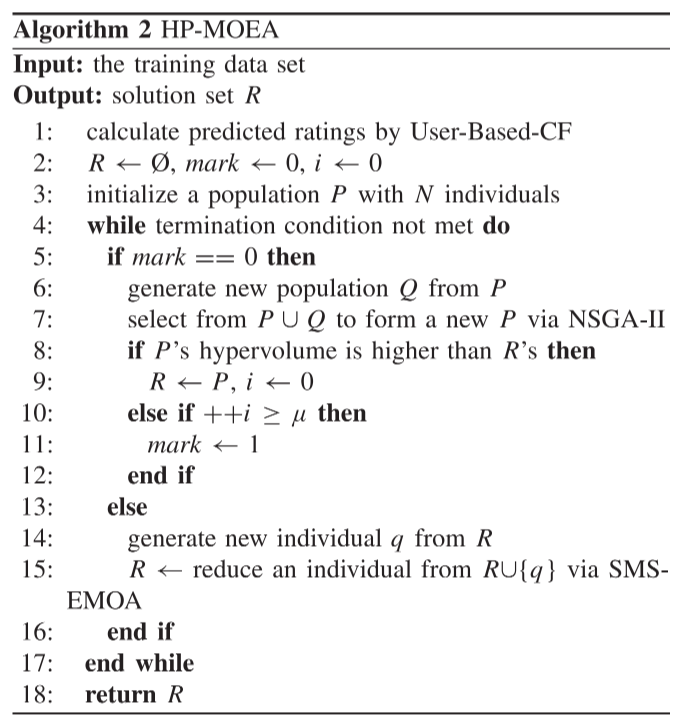

In [19]:
import logger
import copy

def HP_MOEA_LOOP():
    log = logger.logger_class('HP_MOEA_LOOP')
    hp_moea = HP_MOEA_Class()

    log.info('Llamamos al filtrado colaborativo')
    hp_moea.User_based_CF()

    R_population = []
    mark = 0
    i = 0
    population_only_NSGA2 = []

    log.info('Inicializamos la población inicial')
    P_population = hp_moea.generate_initial_population()
    while not hp_moea.termination_condition():
        if mark == 0:
            log.info('Mark es 0, generando población con NSGA-II')

            P_population = hp_moea.generate_new_population_NSGAII()

            P_hypervolume = hp_moea.get_hypervolume_from_population(P_population)
            R_hypervolume = hp_moea.get_hypervolume_from_population(R_population)

            log.info(f'Variables: i = {i}, mark = {mark}, P_hypervolume = {P_hypervolume}, R_hypervolume = {R_hypervolume}')
            if P_hypervolume > R_hypervolume:
                log.info(f'P_hypervolume({P_hypervolume}) > R_hypervolume({R_hypervolume}), R_population <- P_population')
                R_population = copy.deepcopy(P_population)
            elif (i := i + 1) >= u_turning_point:
                log.info('Turning point alcanzado')
                population_only_NSGA2 = copy.deepcopy(R_population)
                mark = 1
            log.info(f'Variables: i = {i}, mark = {mark}')
        else:
            log.info('Mark es 1, generando población con SMS_EMOA')
            R_population = hp_moea.generate_new_population_SMS_EMOA()
        hp_moea.set_population(R_population)

    log.success('Finalizado el algoritmo HP-MOEA correctamente')
    return R_population, population_only_NSGA2

poblacion_final, population_only_NSGA2 = HP_MOEA_LOOP()

[2025-05-05 18:29:28] [INFO] [HP_MOEA_CLASS] [0.00 segundos] Se inicializo una instancia de la clase HP_MOEA_CLASS, la configuración es:
[2025-05-05 18:29:28] [INFO] [HP_MOEA_CLASS] [0.00 segundos] test_mode = True
[2025-05-05 18:29:28] [INFO] [HP_MOEA_CLASS] [0.00 segundos] u_turning_point = 5
[2025-05-05 18:29:28] [INFO] [HP_MOEA_CLASS] [0.00 segundos] L_tamano_lista = 10
[2025-05-05 18:29:28] [INFO] [HP_MOEA_CLASS] [0.00 segundos] N_tamano_poblacion = 100
[2025-05-05 18:29:28] [INFO] [HP_MOEA_CLASS] [0.00 segundos] T_iteraciones = 150
[2025-05-05 18:29:28] [INFO] [HP_MOEA_CLASS] [0.00 segundos] Pm_probabilidad_mutacion = 0.1
[2025-05-05 18:29:28] [INFO] [HP_MOEA_CLASS] [0.00 segundos] r_max_calificacion_maxima = 5
[2025-05-05 18:29:28] [INFO] [HP_MOEA_LOOP] [0.00 segundos] Llamamos al filtrado colaborativo
[2025-05-05 18:29:28] [INFO] [HP_MOEA_CLASS] [0.00 segundos] Inicia el filtrado colaborativo...
[2025-05-05 18:29:28] [INFO] [HP_MOEA_CLASS] [0.00 segundos] La configuración es: U

## Análisis de resultados y visualización
Esta sección presenta los resultados obtenidos y su visualización para facilitar la interpretación del desempeño del algoritmo.

FINAL:
El hipervolumen de la población final es 0.28342689309722713
La población final es de 100 individuos


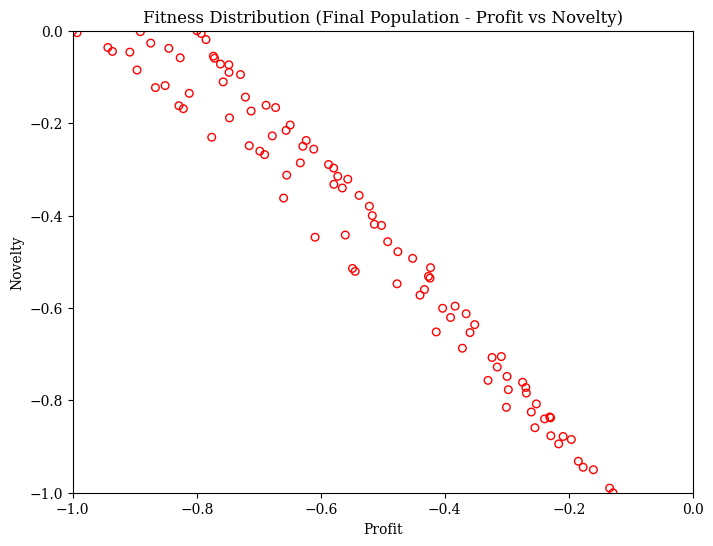

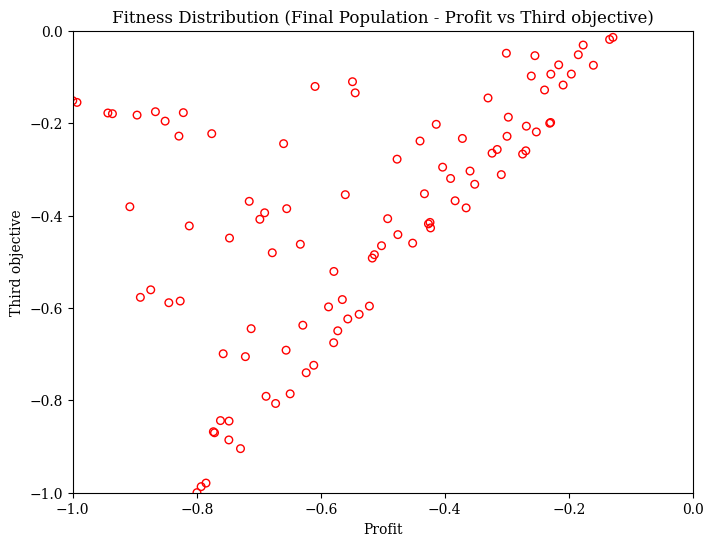

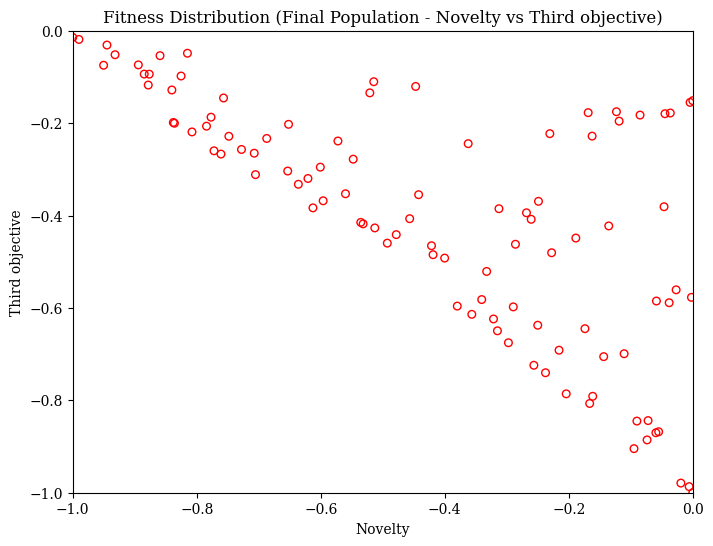

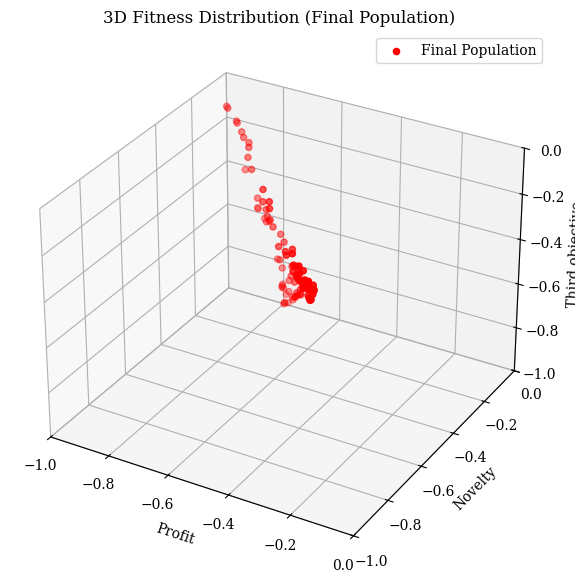

In [20]:
from pymoo.indicators.hv import Hypervolume
from pymoo.visualization.scatter import Scatter

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

log = logger.logger_class('RESULTADOS')
ref_point = np.zeros(n_obj)
hv = Hypervolume(ref_point=ref_point)

show_nsga2 = False

if show_nsga2:
    ### SOLO CON NSGA2
    print(f'NSGA2:')
    fitnessF_only_NSGA2 = population_only_NSGA2.get_fitness_F()
    hv_value_only_NSGA2 = hv.do(fitnessF_only_NSGA2)

    print(f'El hipervolumen de la población solo con NSGA-II es {hv_value_only_NSGA2}')
    print(f'La población solo con NSGA-II es de {len(population_only_NSGA2.get_poblacion_X())} individuos')

    if fitnessF_only_NSGA2.shape[1] == 2:
        plot_ngsa2 = Scatter(
            title="Fitness Distribution (NSGA2 Only)",
            labels=["Profit", "Novelty"]
        )
        plot_ngsa2.add(fitnessF_only_NSGA2, s=30, facecolors='none', edgecolors='b', label="NSGA2 Only")
        plot_ngsa2.show()
        plot_ngsa2.ax.set_xlim(-1, 0)
        plot_ngsa2.ax.set_ylim(-1, 0)
    elif fitnessF_only_NSGA2.shape[1] == 3:
        plot_ngsa2 = Scatter(
            title="Fitness Distribution (NSGA2 Only - Profit vs Novelty)",
            labels=["Profit", "Novelty"]
        )
        plot_ngsa2.add(fitnessF_only_NSGA2[:, [0, 1]], s=30, facecolors='none', edgecolors='b', label="NSGA2 Only")
        plot_ngsa2.show()
        plot_ngsa2.ax.set_xlim(-1, 0)
        plot_ngsa2.ax.set_ylim(-1, 0)

        plot_ngsa2 = Scatter(
            title="Fitness Distribution (NSGA2 Only - Profit vs Third objective)",
            labels=["Profit", "Third objective"]
        )
        plot_ngsa2.add(fitnessF_only_NSGA2[:, [0, 2]], s=30, facecolors='none', edgecolors='b', label="NSGA2 Only")
        plot_ngsa2.show()
        plot_ngsa2.ax.set_xlim(-1, 0)
        plot_ngsa2.ax.set_ylim(-1, 0)

        plot_ngsa2 = Scatter(
            title="Fitness Distribution (NSGA2 Only - Novelty vs Third objective)",
            labels=["Novelty", "Third objective"]
        )
        plot_ngsa2.add(fitnessF_only_NSGA2[:, [1, 2]], s=30, facecolors='none', edgecolors='b', label="NSGA2 Only")
        plot_ngsa2.show()
        plot_ngsa2.ax.set_xlim(-1, 0)
        plot_ngsa2.ax.set_ylim(-1, 0)

### POBLACIÓN FINAL
print(f'FINAL:')
fitnessF = poblacion_final.get_fitness_F()
hv_value = hv.do(fitnessF)

print(f'El hipervolumen de la población final es {hv_value}')
print(f'La población final es de {len(poblacion_final.get_poblacion_X())} individuos')

if fitnessF.shape[1] == 2:
    plot_final = Scatter(
        title="Fitness Distribution (Final Population)",
        labels=["Profit", "Novelty"]
    )
    plot_final.add(fitnessF, s=30, facecolors='none', edgecolors='r', label="Final Population")
    plot_final.show()
    plot_final.ax.set_xlim(-1, 0)
    plot_final.ax.set_ylim(-1, 0)
elif fitnessF.shape[1] == 3:
    plot_final1 = Scatter(
        title="Fitness Distribution (Final Population - Profit vs Novelty)",
        labels=["Profit", "Novelty"]
    )
    plot_final1.add(fitnessF[:, [0, 1]], s=30, facecolors='none', edgecolors='r', label="Final Population")
    plot_final1.show()
    plot_final1.ax.set_xlim(-1, 0)
    plot_final1.ax.set_ylim(-1, 0)

    plot_final2 = Scatter(
        title="Fitness Distribution (Final Population - Profit vs Third objective)",
        labels=["Profit", "Third objective"]
    )
    plot_final2.add(fitnessF[:, [0, 2]], s=30, facecolors='none', edgecolors='r', label="Final Population")
    plot_final2.show()
    plot_final2.ax.set_xlim(-1, 0)
    plot_final2.ax.set_ylim(-1, 0)

    plot_final3 = Scatter(
        title="Fitness Distribution (Final Population - Novelty vs Third objective)",
        labels=["Novelty", "Third objective"]
    )
    plot_final3.add(fitnessF[:, [1, 2]], s=30, facecolors='none', edgecolors='r', label="Final Population")
    plot_final3.show()
    plot_final3.ax.set_xlim(-1, 0)
    plot_final3.ax.set_ylim(-1, 0)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(fitnessF[:, 0], fitnessF[:, 1], fitnessF[:, 2], c='r', marker='o', label="Final Population")

    ax.set_title("3D Fitness Distribution (Final Population)")
    ax.set_xlabel("Profit")
    ax.set_ylabel("Novelty")
    ax.set_zlabel("Third objective")
    ax.set_xlim(-1, 0)
    ax.set_ylim(-1, 0)
    ax.set_zlim(-1, 0)
    ax.legend()
    plt.show()


In [21]:
import matplotlib.pyplot as plt

def calculate_real_total_profit(poblacion):
    real_total_profit = []
    for individuo in poblacion.get_all_individuals():
        matrix = individuo.get_matrix()
        sumatoria = 0
        for user_id, row in enumerate(matrix, start=1):
            for movie in row:
                predict_rating = user_movie_predict_ratings[(user_id, movie)]
                if predict_rating >= 3:
                    sumatoria = sumatoria + movies2profit[movie]
        real_total_profit.append((individuo.get_novelty() / max_novelty, sumatoria))
    # Separate novelty and profit values
    novelty_values, profit_values = zip(*real_total_profit)

    # Plot the real total profit
    plt.figure(figsize=(10, 6))
    plt.scatter(profit_values, novelty_values, color='blue', alpha=0.7)
    plt.title('Novelty vs Real Total Profit')
    plt.xlabel('Real Total Profit')
    plt.ylabel('Novelty')
    plt.grid(True)
    plt.show()
    return real_total_profit

#real_total_profit = calculate_real_total_profit(poblacion_final)

Para animación

In [22]:
import os

def animacion():
    if not os.path.exists('./img'):
        os.makedirs('./img')

    for gen, fitness in enumerate(historial_fitness):
        if gen > 2:
            plot_gen = Scatter(
                title=f"Fitness Distribution (Generation {gen})",
                labels=["Profit", "Novelty"]
            )
            plot_gen.add(fitness, s=30, facecolors='none', edgecolors='g', label=f"Generation {gen - 2}")
            plot_gen.save(f'./img/{gen - 2}.png')

#animacion()

## Ejemplos

In [23]:
import pandas as pd

def load_movie_data(latest):
    """
    Carga los datos de las películas desde un archivo CSV.
    """
    csv = '../../datasets/ml-latest-small/ratings.csv' if latest else '../../datasets/ml-100k/u.item.csv'
    movie_data = pd.read_csv(csv, sep=',', header=None, encoding='latin-1', usecols=[0, 1], names=['movieId', 'title'], skiprows=1)
    return dict(zip(movie_data['movieId'], movie_data['title']))

def get_recommendations(individuos, step_individuo, step_usuarios):
    """
    Obtiene las recomendaciones para los usuarios.
    """
    usuario_lista = []
    j_usuario = 1
    for i_individuo, individuo in enumerate(individuos):
        if i_individuo % step_individuo == 0:
            matrix = individuo.get_matrix()
            usuario_lista.append((j_usuario, matrix[j_usuario - 1], i_individuo, individuo.get_fitness()))
            j_usuario += step_usuarios
    return usuario_lista

def process_recommendations(usuario_lista, movie_id_to_name, new_comers_ids, user_movie_predict_ratings, r_max_calificacion_maxima, movies2profit):
    """
    Procesa las recomendaciones y genera datos tabulares.
    """
    table_data = []
    for usuario, lista_recomendacion, individuo, fitness in usuario_lista:
        fitness_str = ', '.join([f'{obj * -100:.2f}' for obj in fitness])
        print(f'\nIndividuo {individuo}:')
        print(f'  Objetivos: {fitness_str}')
        print(f'  Usuario {usuario}: Recomendaciones:')
        for movie_id in lista_recomendacion:
            if movie_id not in new_comers_ids:
                rating = user_movie_predict_ratings[(usuario, movie_id)]
                profit = movies2profit[movie_id]
                profit_usuario = rating / r_max_calificacion_maxima * profit
                print(f'    - {movie_id_to_name[movie_id]}:')
                print(f'      - Posible rating: {rating:.2f}')
                print(f'      - Profit de la película: {profit:.2f}')
                print(f'      - Profit del usuario-pelicula: {profit_usuario:.2f}')
                table_data.append({
                    'Individuo': individuo,
                    **{f'Objetivo {i+1}': abs(obj) * 100 for i, obj in enumerate(fitness)},
                    'Usuario': usuario,
                    'Movie ID': movie_id,
                    'Movie Title': movie_id_to_name[movie_id],
                    'Predicted Rating': rating,
                    'Movie Profit': profit,
                    'User-Movie Profit': profit_usuario
                })
            else:
                print(f'    - {movie_id_to_name[movie_id]}: New comer')
                table_data.append({
                    'Individuo': individuo,
                    **{f'Objetivo {i+1}': abs(obj) * 100 for i, obj in enumerate(fitness)},
                    'Usuario': usuario,
                    'Movie ID': movie_id,
                    'Movie Title': movie_id_to_name[movie_id],
                    'Predicted Rating': 'New comer',
                    'Movie Profit': 'New comer',
                    'User-Movie Profit': 'New comer'
                })
    return table_data

def save_to_csv(table_data, output_csv):
    """
    Guarda los datos tabulares en un archivo CSV.
    """
    df = pd.DataFrame(table_data)
    df.to_csv(output_csv, index=False, encoding='utf-8')
    print(f'\nLa información tabular ha sido guardada en el archivo: {output_csv}')

# Main execution
log = logger.logger_class('EJEMPLOS')

# Cargar datos de películas
latest = False
movie_id_to_name = load_movie_data(latest)

# Obtener recomendaciones
individuos = poblacion_final.get_all_individuals()
step_individuo = int(len(individuos) / 10)
step_usuarios = int(len(individuos[0].get_matrix()) / 10)
usuario_lista = get_recommendations(individuos, step_individuo, step_usuarios)

# Procesar recomendaciones
table_data = process_recommendations(usuario_lista, movie_id_to_name, new_comers_ids, user_movie_predict_ratings, r_max_calificacion_maxima, movies2profit)

# Guardar resultados en un archivo CSV
output_csv = 'final_recomendations_examples.csv'
save_to_csv(table_data, output_csv)


Individuo 0:
  Objetivos: 12.87, 100.00, 1.44
  Usuario 1: Recomendaciones:
    - Entertaining Angels: The Dorothy Day Story (1996): New comer
    - For Ever Mozart (1996): New comer
    - Butcher Boy, The (1998): New comer
    - Daens (1992): New comer
    - Two or Three Things I Know About Her (1966): New comer
    - Magic Hour, The (1998): New comer
    - Wings of Courage (1995): New comer
    - Cyclo (1995): New comer
    - Amityville: A New Generation (1993): New comer
    - Time Tracers (1995): New comer

Individuo 10:
  Objetivos: 67.29, 16.63, 80.68
  Usuario 95: Recomendaciones:
    - Get Shorty (1995):
      - Posible rating: 3.76
      - Profit de la película: 8.71
      - Profit del usuario-pelicula: 6.54
    - Copycat (1995):
      - Posible rating: 3.10
      - Profit de la película: 8.43
      - Profit del usuario-pelicula: 5.22
    - Shanghai Triad (Yao a yao yao dao waipo qiao) (1995):
      - Posible rating: 3.42
      - Profit de la película: 7.92
      - Profit del